# Example of using EI-ZO for a Kinova Gen 3

In this example we walk through how to set up a plant with model directives and run EI-ZO.

First, we will build a drake plant, and manually recreate it in CSD using the integrated parser.

To get started, make sure to select the python kernel corresponding to your .venv. E.g. when running this notebook in vscode from the example directory, and using the poetry setup described in the README, go to the top right to 'Select Kernel' and select '.venv(Python 3.10.xx)'.

In [1]:
from pydrake.all import (RobotDiagramBuilder, 
                         VisualizationConfig,
                         RigidTransform,
                         Rgba,
                         StartMeshcat, 
                         ApplyVisualizationConfig,
                         ProximityProperties,
                         ModelInstanceIndex,
                         AddContactMaterial,
                         CoulombFriction,
                         Sphere,
                         LoadModelDirectives,
                         ProcessModelDirectives,
                         HPolyhedron,
                         SceneGraphCollisionChecker)
from pycsdecomp import (URDFParser, 
                        EizoOptions,
                        CudaEdgeInflator,
                        CheckCollisionFreeCuda,
                        UniformSampleInHPolyhedraCuda,
                        Voxels,
                        CheckCollisionFreeVoxelsCuda)
import matplotlib.pyplot as plt
from pycsdecomp import HPolyhedron as csdHPoly
from cspace_utils.plotting import plot_triad, plot_hpoly_matplotlib
import numpy as np
import ipywidgets as widgets
from functools import partial
directives_path = '../csdecomp/tests/test_assets/directives/kinova_sens_on_table.yml'
meshcat = StartMeshcat()
rbuilder = RobotDiagramBuilder()
plant= rbuilder.plant()
builder = rbuilder.builder()
parser = rbuilder.parser()
parser.package_map().Add("test_assets", "../csdecomp/tests/test_assets")
parser.package_map().Add("kortex_description", "../csdecomp/tests/test_assets/kinova/kortex_description")
parser.package_map().Add("robotiq_arg85_description", "../csdecomp/tests/test_assets/robotiq")

directives = LoadModelDirectives(directives_path)
models = ProcessModelDirectives(directives, plant, parser)

#add 3 voxels
proximity_properties = ProximityProperties()
AddContactMaterial(dissipation=0.1,
                            point_stiffness=250.0,
                            friction=CoulombFriction(0.9, 0.5),
                            properties=proximity_properties)

vox_loc = np.array([[0.3, 0, 0.5],
                    [0.3, 0.4, 0.5],
                    [0.3, 0.4, 0.6],
                    [0.3, -0.4, 0.5]])
vox_loc = vox_loc.transpose()
vox_radius = 0.02
for i, c in enumerate(vox_loc.T):
    sph_body = plant.AddRigidBody(f"sphere_{i}", model_instance=ModelInstanceIndex(1))
    c3d = c
    plant.WeldFrames(plant.world_frame(), sph_body.body_frame(), RigidTransform(c3d))
    plant.RegisterCollisionGeometry(sph_body,
                                        RigidTransform(), Sphere(vox_radius),
                                        f"sphere_{i}",
                                        proximity_properties
                                        )
    plant.RegisterVisualGeometry(sph_body, RigidTransform(),Sphere(vox_radius),f"sphere_{i}", np.array([0,0,0,1]))
    
scene_graph = rbuilder.scene_graph()
config = VisualizationConfig()
config.enable_alpha_sliders = False
config.publish_contacts=False
config.publish_inertia = False
config.default_proximity_color = Rgba(0.8,0,0,0.5)
#AddDefaultVisualization(builder.builder(), meshcat, enable_alpha_sliders=True)
wrld = plant.GetBodyByName("world")
proximity_properties = ProximityProperties()
plant.Finalize()
ApplyVisualizationConfig(config, builder, meshcat=meshcat)
diagram = rbuilder.Build()
kin_idx = plant.GetModelInstanceByName("kinova")
rob_idx = plant.GetModelInstanceByName("robotiq")
checker = SceneGraphCollisionChecker(model = diagram,
                           robot_model_instances = [kin_idx, rob_idx],
                           edge_step_size = 0.1
                           )

diagram_context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(diagram_context)
diagram.ForcedPublish(diagram_context)

csdecomp_parser = URDFParser()
csdecomp_parser.register_package("test_assets", "../csdecomp/tests/test_assets/")
csdecomp_parser.parse_directives("../csdecomp/tests/test_assets/directives/kinova_sens_on_table.yml")
kt = csdecomp_parser.get_kinematic_tree()
mkt= csdecomp_parser.get_minimal_kinematic_tree()
mp = csdecomp_parser.get_minimal_plant()
meshcat.SetProperty('/drake/proximity', 'visible', True)

insp = csdecomp_parser.get_scene_inspector()
csdecomp_robgeomid = insp.robot_geometry_ids
csdecomp_vox = Voxels(vox_loc)

csdecomp_domain = csdHPoly()
csdecomp_domain.MakeBox(kt.get_position_lower_limits(), kt.get_position_upper_limits())
options = EizoOptions()
options.num_particles = 10000
options.bisection_steps = 9
options.configuration_margin = 0.1
options.delta = 0.01
options.epsilon = 0.01
options.tau = 0.5
options.mixing_steps = 100
options.max_hyperplanes_per_iteration = 10
edge_inflator = CudaEdgeInflator(mp, insp.robot_geometry_ids, options, csdecomp_domain)

INFO:drake:Meshcat listening for connections at http://localhost:7000
INFO:drake:Allocating contexts to support implicit context parallelism 20


Successfully registered package 'test_assets' with path: ../csdecomp/tests/test_assets/


In [2]:
q = np.zeros(plant.num_positions()) 
sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]*0.99
    q_high = plant.GetPositionUpperLimits()[i]*0.99
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, step=0.001, description=f"q{i}"))

def handle_slider_change(change, idx):

    q[idx] = change['new']
    plant.SetPositions(plant_context, q)
    query = plant.get_geometry_query_input_port().Eval(plant_context)
    
    if query.HasCollisions():
        print('in collision!')
        csd_col = not CheckCollisionFreeVoxelsCuda(q, csdecomp_vox, vox_radius, mp, csdecomp_robgeomid)[0]
        print(f"[CSD] Has collision? {csd_col}")
    col_free_csdecomp = CheckCollisionFreeVoxelsCuda(q, csdecomp_vox, vox_radius, mp, csdecomp_robgeomid)[0]
    col_free_drake = not query.HasCollisions()
    if col_free_csdecomp != col_free_drake:
        raise ValueError("Careful there is a mismatch between drakes collision checker, and CSD's. \
                         This can happen in rare instances becasue drake adds some padding.")
    # uncomment to visualize frames

    # transforms = kt.compute_link_frame_to_world_transforms(q)
    # transforms_minimal = computeLinkFrameToWorldTransformsMinimal(q, mkt)
    # rts_ = [RigidTransform(r) for r in transforms]
    # for i, rt in enumerate(rts_):
    #     plot_triad(rt, meshcat, f"full/link_frame_{i}")
    diagram.ForcedPublish(diagram_context)    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=3.069, min=-3.069, step=0.001)

FloatSlider(value=0.0, description='q1', max=2.2176, min=-2.2176, step=0.001)

FloatSlider(value=0.0, description='q2', max=3.069, min=-3.069, step=0.001)

FloatSlider(value=0.0, description='q3', max=2.5443, min=-2.5443, step=0.001)

FloatSlider(value=0.0, description='q4', max=3.069, min=-3.069, step=0.001)

FloatSlider(value=0.0, description='q5', max=2.0690999999999997, min=-2.0690999999999997, step=0.001)

FloatSlider(value=0.0, description='q6', max=3.069, min=-3.069, step=0.001)

# Using EI-ZO

In [3]:
l_start = np.array([-0.376 ,  0.3714,  0.,  0.,  0.,  0.,  0.])
l_end = np.array([-0.376 ,  1.2024,  0.,  0. ,  0. ,  0. ,  0. ])
#burn in run
region = edge_inflator.inflateEdge(l_start, l_end, csdecomp_vox, vox_radius, False)
#print out timing info
region = edge_inflator.inflateEdge(l_start, l_end, csdecomp_vox, vox_radius, True)

======================== Set builder ===========================
EI-ZO Summary:
Total iterations: 4

Iter.   Samples   Col. (UT)   Thresh.   Col. (OPT)  Faces   Time (ms)   
------------------------------------------------------------------------
0       10000     1776        20        4321        10      4.00        
1       10000     2365        25        4650        10      4.00        
2       10000     1204        29        2092        4       4.00        
3       10000     0           31        0           0       3.00        
------------------------------------------------------------------------
Totals:
  Samples drawn: 40000
  Collisions (UT): 5345
  Collisions (OPT): 11063
  Faces placed: 24
  Total time: 15.00 ms
===================== End Set builder ===========================


# Visualizing a tangent slice of the generated convex set

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-08


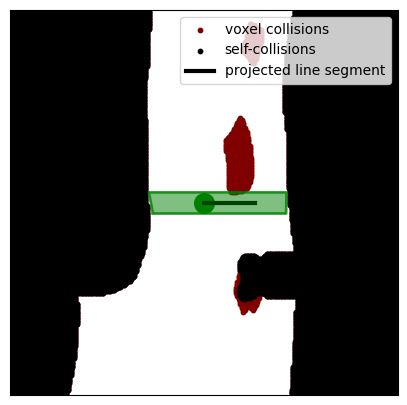

In [4]:
regions_to_plot = [HPolyhedron(r.A(), r.b()) for r in [region]]
fig,ax = plt.subplots(figsize = (5,5))

#setting the arm to the position visualized in the slice
plant.SetPositions(plant_context, l_start)
diagram.ForcedPublish(diagram_context)

tvals = []
for x in np.linspace(-np.pi, np.pi, 250):
    for y in np.linspace(-np.pi, np.pi, 250):
        tvals.append(np.array([x,y]))
tvals = np.array(tvals)

perp_dir = (np.random.rand(7)-0.5)  # Initialize this with your initial perp_dir value
dir = l_end-l_start
dir /= np.linalg.norm(dir)
rand_e_comp = (dir @ perp_dir) * dir
rand_normal = perp_dir - rand_e_comp
rand_normal /= np.linalg.norm(rand_normal)
projector = np.array([dir, rand_normal])
proj_line = (projector @ (l_end - l_start)).T
points = (projector.T @ tvals.T).T + l_start.reshape(1, 7)

col_free = CheckCollisionFreeVoxelsCuda(points.T, 
                                        csdecomp_vox, vox_radius, 
                                        mp, 
                                        csdecomp_robgeomid)

col_idx = np.where(1 - 1.0 * np.array(col_free))[0]
ax.scatter(tvals[col_idx][:, 0], tvals[col_idx][:, 1], c='maroon', s=10, zorder =0, label ='voxel collisions')
col_free = CheckCollisionFreeCuda(points.T, 
                                        mp)

col_idx = np.where(1 - 1.0 * np.array(col_free))[0]
ax.scatter(tvals[col_idx][:, 0], tvals[col_idx][:, 1], c='k', s=10, zorder = 1, label = "self-collisions")
ax.scatter(0, 0, s=200, c='g')
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-np.pi, np.pi])
ax.plot([0,proj_line[0]], 
        [0, proj_line[1]], 
        linewidth =3, 
        color = 'k', 
        label ='projected line segment')
ax.xaxis.set_tick_params(bottom=False, top=False, labelbottom=False)
ax.yaxis.set_tick_params(left=False, right=False, labelleft=False)
for i, r in enumerate(regions_to_plot):
    A_aux = r.A() @ projector.T
    b_aux = -r.A() @ l_start + r.b()
    reg_slice = HPolyhedron(A_aux, b_aux)
    if not reg_slice.IsEmpty():
        plot_hpoly_matplotlib(ax, reg_slice, color='g', zorder=i * 2+5)
ax.legend(loc='upper right')